In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [ ]:
print(torch.__version__)

1.2.0+cu92


In [1]:
from transformers import (
    pipeline,
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoModelForMaskedLM,
    AutoModelForQuestionAnswering,
    AutoModelForSeq2SeqLM,
    AutoModelForCausalLM,
)
import torch

In [8]:
def manual_tokenization_and_inference():
    """Show how to call tokenizer + model directly, with robust mask handling."""
    import torch
    from transformers import AutoTokenizer, AutoModelForMaskedLM

    print("=== Manual Masked-LM Demo ===")
    model_name = "bert-base-uncased"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForMaskedLM.from_pretrained(model_name)

    # Insert the real mask token into your text
    text = f"The quick brown fox jumps over the lazy {tokenizer.mask_token}."
    inputs = tokenizer(text, return_tensors="pt")

    # Locate all mask positions: (batch_idx, seq_pos)
    batch_idxs, seq_idxs = (inputs["input_ids"] == tokenizer.mask_token_id).nonzero(as_tuple=True)

    if seq_idxs.numel() == 0:
        raise ValueError(
            f"No mask token found in the input! "
            f"Make sure to include {tokenizer.mask_token!r} in your string."
        )
# If you only ever expect one mask per example, just grab the first
    batch_idx = batch_idxs[0].item()
    mask_pos = seq_idxs[0].item()
    print(f"Found mask in example {batch_idx} at position {mask_pos}")

    # Inference
    with torch.no_grad():
        logits = model(**inputs).logits  # (batch, seq_len, vocab_size)

    # Compute probabilities for the masked position
    softmax = torch.nn.functional.softmax(logits[batch_idx, mask_pos], dim=-1)
    top5 = torch.topk(softmax, k=5)

    print("Input text:", text)
    print("Top-5 predictions for the mask:")
    for score, token_id in zip(top5.values.tolist(), top5.indices.tolist()):
        token = tokenizer.decode([token_id]).strip()
        print(f"  {token:>10}  (score: {score:.4f})")
    print()

As I have done in my previous tutorials, I always encourage to test the model with 1 batch to ensure that the output dimensions are what we expect.

In [9]:
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForMaskedLM.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [10]:
text = f"The quick brown fox jumps over the lazy {tokenizer.mask_token}."
inputs = tokenizer(text, return_tensors="pt")

In [11]:
print(inputs)

{'input_ids': tensor([[  101,  1996,  4248,  2829,  4419, 14523,  2058,  1996, 13971,   103,
          1012,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


In [12]:
inputs['input_ids']

tensor([[  101,  1996,  4248,  2829,  4419, 14523,  2058,  1996, 13971,   103,
          1012,   102]])

In [13]:
batch_idxs, seq_idxs = (inputs["input_ids"] == tokenizer.mask_token_id).nonzero(as_tuple=True)

In [14]:
with torch.no_grad():
        logits = model(**inputs).logits

In [15]:
logits.shape

torch.Size([1, 12, 30522])

In [16]:
batch_idx = batch_idxs[0].item()
mask_pos = seq_idxs[0].item()

In [17]:
softmax = torch.nn.functional.softmax(logits[batch_idx, mask_pos], dim=-1)

In [18]:
top5 = torch.topk(softmax, k=5)

In [19]:
for score, token_id in zip(top5.values.tolist(), top5.indices.tolist()):
        token = tokenizer.decode([token_id]).strip()
        print(f"  {token:>10}  (score: {score:.4f})")

       water  (score: 0.1065)
       river  (score: 0.0641)
       grass  (score: 0.0578)
      stream  (score: 0.0385)
        lake  (score: 0.0205)


In [4]:
from transformers import BertTokenizer, BertModel
import torch
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [5]:
tok = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased').eval()
token_id = tok.convert_tokens_to_ids('bank')
emb_matrix = model.get_input_embeddings().weight  # shape (30522, 768)
static_vec = emb_matrix[token_id]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [6]:
emb_matrix

Parameter containing:
tensor([[-0.0102, -0.0615, -0.0265,  ..., -0.0199, -0.0372, -0.0098],
        [-0.0117, -0.0600, -0.0323,  ..., -0.0168, -0.0401, -0.0107],
        [-0.0198, -0.0627, -0.0326,  ..., -0.0165, -0.0420, -0.0032],
        ...,
        [-0.0218, -0.0556, -0.0135,  ..., -0.0043, -0.0151, -0.0249],
        [-0.0462, -0.0565, -0.0019,  ...,  0.0157, -0.0139, -0.0095],
        [ 0.0015, -0.0821, -0.0160,  ..., -0.0081, -0.0475,  0.0753]],
       requires_grad=True)

In [1]:
s1 = "He sat by the river bank and watched the water flow."
s2 = "She deposited her paycheck in the bank before heading home."

In [7]:
inputs1 = tok(s1, return_tensors='pt')
inputs2 = tok(s2, return_tensors='pt')
with torch.no_grad():
    out1 = model(**inputs1).last_hidden_state  # (1, seq_len1, 768)
    out2 = model(**inputs2).last_hidden_state  # (1, seq_len2, 768)

In [8]:
idx1 = inputs1['input_ids'][0].tolist().index(tok.convert_tokens_to_ids('bank'))
idx2 = inputs2['input_ids'][0].tolist().index(tok.convert_tokens_to_ids('bank'))
ctx1 = out1[0, idx1]   # shape (768,)
ctx2 = out2[0, idx2]   # shape (768,)

In [9]:
ctx1

tensor([ 2.7909e-01, -3.6550e-01, -2.3399e-01, -3.1686e-01, -5.5243e-01,
         7.1478e-02,  3.7379e-01,  1.0465e+00,  4.3768e-02, -7.5979e-01,
         8.7392e-01,  1.6043e-01,  1.5766e-01,  2.9110e-01, -1.8853e-01,
         2.2815e-01,  7.1313e-02, -1.2895e-01,  5.7778e-01, -8.4729e-02,
         5.7158e-01,  2.3038e-01,  4.6560e-01,  1.0824e-01,  4.1697e-01,
         4.4395e-02,  5.8678e-01, -3.9542e-01,  1.3714e-01,  5.8010e-01,
         1.2936e+00,  2.7328e-01, -9.7948e-02,  1.5093e-01, -2.6122e-01,
         1.8543e-01, -7.7961e-02, -4.7832e-01, -3.0389e-01,  7.3062e-01,
        -6.2942e-01, -9.1302e-01, -6.3676e-01,  8.9127e-01,  3.0237e-01,
         8.6045e-03, -2.0530e-01, -6.0616e-02, -4.0033e-01,  7.2135e-01,
        -5.3626e-01,  8.5464e-01, -3.4158e-01, -4.8237e-01,  1.7603e-01,
         4.6752e-01, -5.9916e-01, -1.2642e+00, -3.2287e-01,  1.5495e-01,
         5.8573e-01,  2.0572e-01,  3.3430e-02, -5.8585e-01,  1.9671e-01,
        -1.5365e-01, -1.4837e-01, -4.9790e-01, -5.9

In [10]:
ctx2

tensor([ 0.6230, -0.6725,  0.4485, -0.0329,  0.6518,  0.4787, -0.1686,  0.7740,
         0.2872,  0.1143,  0.4821, -0.1183,  0.0715,  0.4052, -0.6511, -0.4321,
         0.1693,  0.5248,  1.0963, -0.0265, -0.2420, -0.0029,  0.3207,  0.1604,
         0.4125,  0.2633,  0.1816,  0.1035,  0.1152, -0.6607,  0.4355,  0.3528,
         0.1719,  0.6071,  0.3249, -0.0314,  0.0143,  0.0265, -0.9579,  0.2709,
        -0.7166, -0.6346, -0.7237,  0.1520,  0.1976, -0.0714, -0.1694,  0.3211,
        -0.3222, -0.1733, -0.3705,  0.6462,  0.5452, -0.3504,  0.6164,  0.7543,
        -0.7588, -0.8547, -1.2388, -0.2448,  0.7993,  0.4415,  0.9062, -1.3952,
         0.4310, -0.5691, -0.1310,  0.0082, -0.6918,  0.0035, -0.2307,  1.9578,
        -0.3262, -0.4591, -0.5800,  1.0802, -0.6557,  0.0632, -0.1033, -0.3062,
        -0.5148, -0.8000,  0.1736,  0.1640,  0.3323, -0.1259, -0.1470,  0.1456,
        -0.9023,  0.7333, -0.5282,  0.2590, -0.6189, -0.1930, -0.5592, -0.7500,
         0.2309,  0.1666, -0.9841,  0.40

In [11]:
import torch.nn.functional as F
# Assume static_vec, ctx1, ctx2 are all 1D tensors of the same size, e.g. (768,)

# PyTorch’s cosine_similarity expects at least 2D (batch) tensors, so we add a dummy batch dim:
static_batch = static_vec.unsqueeze(0)  # shape (1, d)
ctx1_batch   = ctx1.unsqueeze(0)        # shape (1, d)
ctx2_batch   = ctx2.unsqueeze(0)        # shape (1, d)

# Compute cosine similarities (returns a tensor of shape (1,))
sim1 = F.cosine_similarity(static_batch, ctx1_batch)  # similarity between static and ctx1
sim2 = F.cosine_similarity(static_batch, ctx2_batch)  # similarity between static and ctx2

print(f"Static vs. 'river' context similarity:    {sim1.item():.4f}")
print(f"Static vs. 'financial' context similarity: {sim2.item():.4f}")

Static vs. 'river' context similarity:    0.2181
Static vs. 'financial' context similarity: 0.2570


In [12]:
cls1 = out1[0,0]
cls2 = out2[0,0]

In [13]:
mean1 = out1.mean(dim=1)[0]
mean2 = out2.mean(dim=1)[0]

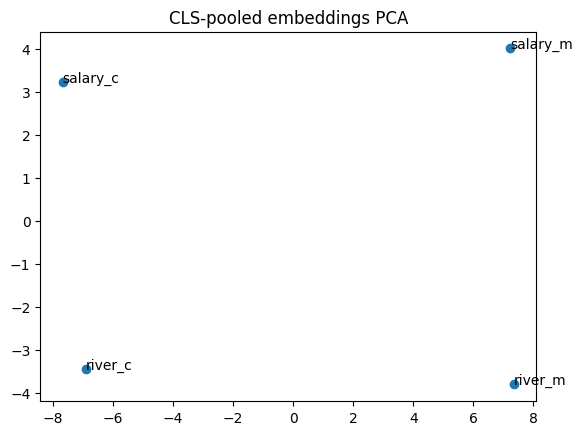

In [14]:
vectors = torch.stack([cls1, cls2, mean1, mean2]).numpy()
pca = PCA(n_components=2).fit_transform(vectors)
plt.scatter(pca[:,0], pca[:,1])
for i, label in enumerate(['river_c','salary_c','river_m','salary_m']):
    plt.annotate(label, (pca[i,0], pca[i,1]))
plt.title("CLS‐pooled embeddings PCA")
plt.show()

In [15]:
s3 = 'I have no money in my bank account'

In [19]:
from transformers import AutoTokenizer, AutoModel

In [20]:
model_name = "bert-base-uncased"   # or whatever checkpoint you’re using
tokenizer = AutoTokenizer.from_pretrained(model_name)
model= AutoModel.from_pretrained(model_name)

In [23]:
cls3  = out3[0, 0]                # CLS‐token embedding
mean3 = out3.mean(dim=1)[0]

In [22]:

# 1. Encode s3 and extract CLS‐ and mean‐pooled embeddings
s3 = "I have no money in my bank account"
inputs3 = tokenizer(s3, return_tensors="pt")
out3 = model(**inputs3).last_hidden_state

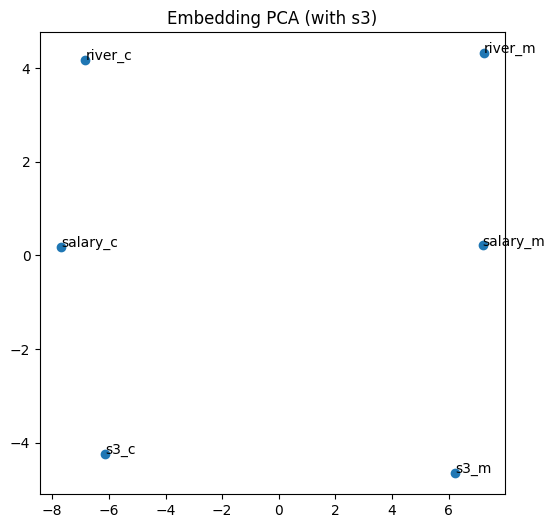

In [27]:
# Stack your 6 vectors, detach from the graph, move to CPU, then convert to NumPy
vectors = torch.stack([cls1, cls2, cls3, mean1, mean2, mean3]) \
               .detach() \
               .cpu() \
               .numpy()

labels  = ["river_c","salary_c","s3_c","river_m","salary_m","s3_m"]

pca_coords = PCA(n_components=2).fit_transform(vectors)

plt.figure(figsize=(6,6))
plt.scatter(pca_coords[:,0], pca_coords[:,1])
for i, lbl in enumerate(labels):
    plt.annotate(lbl, (pca_coords[i,0], pca_coords[i,1]))
plt.title("Embedding PCA (with s3)")
plt.show()


In [28]:
# Assuming you already have:
#   static_batch: 1×d tensor (static_vec.unsqueeze(0))
#   cls3:         d-dim tensor for s3’s [CLS] embedding

import torch.nn.functional as F

# 1. Compute sim3 (detach+cpu in case you're on GPU)
sim3 = F.cosine_similarity(static_batch, cls3.unsqueeze(0)) \
          .detach() \
          .cpu() \
          .item()

# 2. Print it
print(f"Static vs. s3 context similarity: {sim3:.4f}")

Static vs. s3 context similarity: -0.0035


In [29]:
import torch.nn.functional as F

# Assuming you already have these tensors in scope:
# cls1, cls2:       (d,) CLS‐pooled embeddings for ctx1 and ctx2
# mean1, mean2:     (d,) mean‐pooled embeddings for ctx1 and ctx2
# cls3, mean3:      (d,) embeddings for s3 (“I have no money…”)

# Add the dummy batch dimension
cls1_batch  = cls1.unsqueeze(0)   # shape (1, d)
cls2_batch  = cls2.unsqueeze(0)
mean1_batch = mean1.unsqueeze(0)
mean2_batch = mean2.unsqueeze(0)

cls3_batch  = cls3.unsqueeze(0)
mean3_batch = mean3.unsqueeze(0)

# Cosine similarities (CLS‐pooled)
sim3_1_cls = F.cosine_similarity(cls3_batch, cls1_batch).item()
sim3_2_cls = F.cosine_similarity(cls3_batch, cls2_batch).item()

# Cosine similarities (mean‐pooled)
sim3_1_mean = F.cosine_similarity(mean3_batch, mean1_batch).item()
sim3_2_mean = F.cosine_similarity(mean3_batch, mean2_batch).item()

print(f"CLS pooling:   s3 vs. ctx1 = {sim3_1_cls:.4f},   s3 vs. ctx2 = {sim3_2_cls:.4f}")
print(f"Mean pooling:  s3 vs. ctx1 = {sim3_1_mean:.4f},  s3 vs. ctx2 = {sim3_2_mean:.4f}")

CLS pooling:   s3 vs. ctx1 = 0.7991,   s3 vs. ctx2 = 0.8612
Mean pooling:  s3 vs. ctx1 = 0.5242,  s3 vs. ctx2 = 0.6033


In [31]:
inputs3 = tok(s3, return_tensors='pt')
with torch.no_grad():
    out3 = model(**inputs3).last_hidden_state

In [32]:
idx3 = inputs3['input_ids'][0].tolist().index(tok.convert_tokens_to_ids('bank'))
ctx3 = out3[0, idx3]   # shape (768,)

In [35]:
corpus = [
    "The Eiffel Tower is an iron lattice tower located on the Champ de Mars in Paris, France.",
    "Honeybees communicate through a waggle dance to tell hive-mates the direction and distance of food sources.",
    "Quantum computing leverages quantum bits, or qubits, to perform certain calculations far more efficiently than classical computers.",
    "The Mona Lisa, painted by Leonardo da Vinci in the early 16th century, is displayed in the Louvre Museum in Paris.",
    "Mitochondria are membrane-bound organelles in eukaryotic cells that generate most of the cell’s supply of ATP."
]

In [36]:
query = "Where can I see Leonardo da Vinci’s famous portrait?"

In [37]:
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model     = AutoModel.from_pretrained(model_name)

In [38]:
inputs_q = tokenizer(query, return_tensors="pt")
out_q     = model(**inputs_q).last_hidden_state  # (1, seq_len, d)
cls_q     = out_q[0,0]                           # (d,)
cls_q_batch = cls_q.unsqueeze(0)

In [39]:
sims = []
for sent in corpus:
    inputs_c   = tokenizer(sent, return_tensors="pt")
    out_c      = model(**inputs_c).last_hidden_state
    cls_c      = out_c[0,0]                       # (d,)
    cls_c_batch = cls_c.unsqueeze(0)

    sim = F.cosine_similarity(cls_q_batch, cls_c_batch) \
             .item()
    sims.append(sim)

In [40]:
best_idx = int(torch.tensor(sims).argmax())
best_sent = corpus[best_idx]
best_sim  = sims[best_idx]

print(f"Most relevant response (score={best_sim:.4f}):\n{best_sent}")

Most relevant response (score=0.7873):
The Mona Lisa, painted by Leonardo da Vinci in the early 16th century, is displayed in the Louvre Museum in Paris.


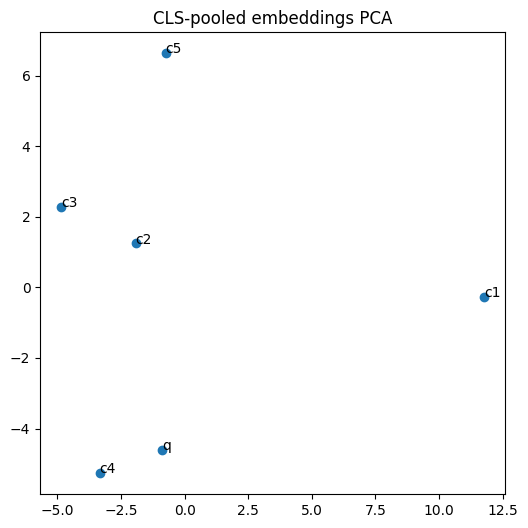

In [44]:
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 1) Init model & tokenizer
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model     = AutoModel.from_pretrained(model_name)

# 2) Your query and corpus
query  = "Where can I see Leonardo da Vinci’s famous portrait?"
corpus = [
    "The Eiffel Tower is an iron lattice tower located on the Champ de Mars in Paris, France.",
    "Honeybees communicate through a waggle dance to tell hive-mates the direction and distance of food sources.",
    "Quantum computing leverages quantum bits, or qubits, to perform certain calculations far more efficiently than classical computers.",
    "The Mona Lisa, painted by Leonardo da Vinci in the early 16th century, is displayed in the Louvre Museum in Paris.",
    "Mitochondria are membrane-bound organelles in eukaryotic cells that generate most of the cell’s supply of ATP."
]

# 3) Encode the query CLS embedding
inputs_q    = tokenizer(query, return_tensors="pt")
out_q       = model(**inputs_q).last_hidden_state
cls_q       = out_q[0,0].detach()          # detach from graph
# (no batch dim needed until similarity/PCA)

# 4) Loop over corpus, get CLS for each sentence
cls_list = []
for sent in corpus:
    inputs_c = tokenizer(sent, return_tensors="pt")
    out_c    = model(**inputs_c).last_hidden_state
    cls_c    = out_c[0,0].detach()          # (d,)
    cls_list.append(cls_c)

# 5) Now build your PCA matrix: five corpus vectors + the query
vecs = cls_list + [cls_q]                   # list of 6 tensors
# stack, move to CPU, convert to NumPy
vectors = torch.stack(vecs).cpu().numpy()   # shape (6, d)

# 6) Run PCA and plot
pca_coords = PCA(n_components=2).fit_transform(vectors)

plt.figure(figsize=(6,6))
plt.scatter(pca_coords[:,0], pca_coords[:,1])
labels = ['c1','c2','c3','c4','c5','q']
for i, lbl in enumerate(labels):
    plt.annotate(lbl, (pca_coords[i,0], pca_coords[i,1]))
plt.title("CLS‐pooled embeddings PCA")
plt.show()


In [45]:
from transformers import pipeline

# 1) Initialize a QA pipeline
qa = pipeline("question-answering", model="distilbert-base-uncased-distilled-squad")

# 2) Your query and retrieved context

retrieved = corpus[3]

# 3) Run QA
result = qa(question=query, context=retrieved)

print("Answer:", result["answer"])

config.json:   0%|          | 0.00/451 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Device set to use cuda:0


Answer: Louvre Museum in Paris


In [46]:
from transformers import pipeline

# 1) Initialize a text2text‐generation pipeline (T5, for example)
t5 = pipeline("text2text-generation", model="t5-small")

# 2) Format input with both the question and the retrieved passage
input_text = (
    "question: " + query +
    "context: " + corpus[3]

)

# 3) Generate
out = t5(input_text, max_length=50, num_return_sequences=1)
print("Response:", out[0]["generated_text"])

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

Device set to use cuda:0
Both `max_new_tokens` (=256) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Louvre Museum in Paris
